# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 46kB/s  eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

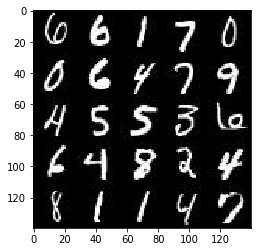

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

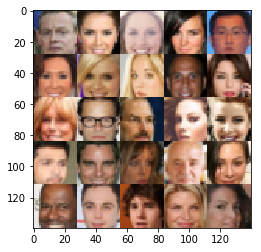

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    input_z = tf.placeholder(tf.float32, [None, z_dim])
    learn_rate = tf.placeholder(tf.float32)
    
    return input_real, input_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):

        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)

        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)

        
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        
        logits = tf.layers.dense(flat, 1)
        
        out = tf.tanh(logits)
        
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=True)
        x1 = tf.maximum(0.2 * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(0.2 * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(0.2 * x3, x3)

        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28xoutputdim now
        
        out = tf.tanh(logits)
        
        return out


    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)*0.9))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)*0.9))
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [13]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z,image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    steps = 0            
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_opt, feed_dict={input_z:batch_z, input_real:batch_images,learn_rate:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z:batch_z, input_real:batch_images, learn_rate:learning_rate})
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real:batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:
                       _ = show_generator_output(sess, 30, input_z, image_channels, data_image_mode)                  

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.8455... Generator Loss: 11.2052
Epoch 1/2... Discriminator Loss: 0.3577... Generator Loss: 5.1658
Epoch 1/2... Discriminator Loss: 0.5667... Generator Loss: 2.3640
Epoch 1/2... Discriminator Loss: 0.5432... Generator Loss: 3.7456
Epoch 1/2... Discriminator Loss: 0.9328... Generator Loss: 3.1699
Epoch 1/2... Discriminator Loss: 0.3813... Generator Loss: 6.0384
Epoch 1/2... Discriminator Loss: 1.1876... Generator Loss: 2.2215
Epoch 1/2... Discriminator Loss: 0.5533... Generator Loss: 1.8925
Epoch 1/2... Discriminator Loss: 0.5288... Generator Loss: 2.4140
Epoch 1/2... Discriminator Loss: 1.4476... Generator Loss: 0.7308


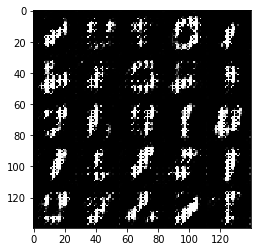

Epoch 1/2... Discriminator Loss: 1.4416... Generator Loss: 0.6031
Epoch 1/2... Discriminator Loss: 1.0274... Generator Loss: 1.1337
Epoch 1/2... Discriminator Loss: 1.4316... Generator Loss: 1.7215
Epoch 1/2... Discriminator Loss: 1.0701... Generator Loss: 1.4580
Epoch 1/2... Discriminator Loss: 1.4042... Generator Loss: 0.5881
Epoch 1/2... Discriminator Loss: 1.0423... Generator Loss: 1.4726
Epoch 1/2... Discriminator Loss: 0.9828... Generator Loss: 0.9922
Epoch 1/2... Discriminator Loss: 1.5446... Generator Loss: 0.5462
Epoch 1/2... Discriminator Loss: 0.9144... Generator Loss: 1.2137
Epoch 1/2... Discriminator Loss: 1.3618... Generator Loss: 0.6225


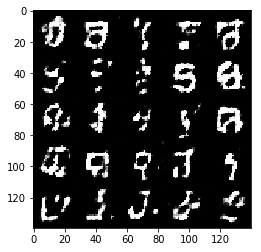

Epoch 1/2... Discriminator Loss: 1.1887... Generator Loss: 2.3348
Epoch 1/2... Discriminator Loss: 1.1090... Generator Loss: 0.8907
Epoch 1/2... Discriminator Loss: 1.5192... Generator Loss: 2.0752
Epoch 1/2... Discriminator Loss: 1.0387... Generator Loss: 0.9860
Epoch 1/2... Discriminator Loss: 1.1980... Generator Loss: 0.7999
Epoch 1/2... Discriminator Loss: 1.0669... Generator Loss: 0.9092
Epoch 1/2... Discriminator Loss: 1.1076... Generator Loss: 1.1128
Epoch 1/2... Discriminator Loss: 1.3903... Generator Loss: 1.7435
Epoch 1/2... Discriminator Loss: 1.5601... Generator Loss: 0.4842
Epoch 1/2... Discriminator Loss: 1.1752... Generator Loss: 1.0338


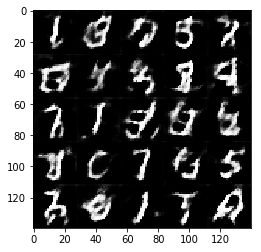

Epoch 1/2... Discriminator Loss: 1.1416... Generator Loss: 0.8520
Epoch 1/2... Discriminator Loss: 1.2060... Generator Loss: 0.9204
Epoch 1/2... Discriminator Loss: 1.2321... Generator Loss: 0.9889
Epoch 1/2... Discriminator Loss: 1.3104... Generator Loss: 0.7029
Epoch 1/2... Discriminator Loss: 1.2541... Generator Loss: 1.1940
Epoch 1/2... Discriminator Loss: 1.1566... Generator Loss: 1.0201
Epoch 1/2... Discriminator Loss: 1.2484... Generator Loss: 0.7907
Epoch 1/2... Discriminator Loss: 1.4778... Generator Loss: 0.5342
Epoch 1/2... Discriminator Loss: 1.1888... Generator Loss: 1.4400
Epoch 1/2... Discriminator Loss: 1.2658... Generator Loss: 0.6910


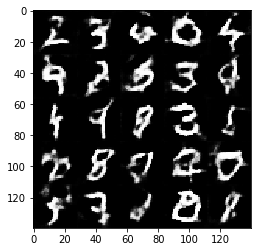

Epoch 1/2... Discriminator Loss: 1.2652... Generator Loss: 0.9792
Epoch 1/2... Discriminator Loss: 1.2927... Generator Loss: 1.1695
Epoch 1/2... Discriminator Loss: 1.2252... Generator Loss: 1.1511
Epoch 1/2... Discriminator Loss: 1.3960... Generator Loss: 0.5618
Epoch 1/2... Discriminator Loss: 1.1628... Generator Loss: 1.3326
Epoch 1/2... Discriminator Loss: 1.0748... Generator Loss: 1.0991
Epoch 1/2... Discriminator Loss: 1.1662... Generator Loss: 0.9029
Epoch 1/2... Discriminator Loss: 1.2782... Generator Loss: 0.6464
Epoch 1/2... Discriminator Loss: 1.1198... Generator Loss: 0.9205
Epoch 1/2... Discriminator Loss: 1.3945... Generator Loss: 0.5820


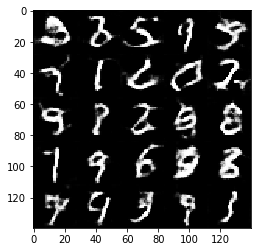

Epoch 1/2... Discriminator Loss: 1.1579... Generator Loss: 0.7138
Epoch 1/2... Discriminator Loss: 1.2182... Generator Loss: 0.7985
Epoch 1/2... Discriminator Loss: 1.2629... Generator Loss: 0.6464
Epoch 1/2... Discriminator Loss: 1.2853... Generator Loss: 1.4707
Epoch 1/2... Discriminator Loss: 1.1104... Generator Loss: 1.2056
Epoch 1/2... Discriminator Loss: 1.3964... Generator Loss: 0.5567
Epoch 1/2... Discriminator Loss: 1.0948... Generator Loss: 0.9504
Epoch 1/2... Discriminator Loss: 1.2772... Generator Loss: 0.7687
Epoch 1/2... Discriminator Loss: 1.0398... Generator Loss: 1.0001
Epoch 1/2... Discriminator Loss: 1.1209... Generator Loss: 1.0005


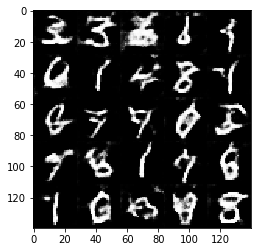

Epoch 1/2... Discriminator Loss: 1.1197... Generator Loss: 1.0351
Epoch 1/2... Discriminator Loss: 1.4435... Generator Loss: 0.5363
Epoch 1/2... Discriminator Loss: 1.1858... Generator Loss: 1.2925
Epoch 1/2... Discriminator Loss: 2.1336... Generator Loss: 1.9992
Epoch 1/2... Discriminator Loss: 1.0735... Generator Loss: 1.0390
Epoch 1/2... Discriminator Loss: 1.0950... Generator Loss: 0.8876
Epoch 1/2... Discriminator Loss: 1.0568... Generator Loss: 0.8585
Epoch 1/2... Discriminator Loss: 1.2676... Generator Loss: 1.4632
Epoch 1/2... Discriminator Loss: 1.2974... Generator Loss: 0.6045
Epoch 1/2... Discriminator Loss: 1.5883... Generator Loss: 0.5341


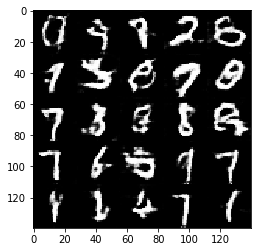

Epoch 1/2... Discriminator Loss: 1.1414... Generator Loss: 0.7986
Epoch 1/2... Discriminator Loss: 1.0994... Generator Loss: 1.4445
Epoch 1/2... Discriminator Loss: 1.1671... Generator Loss: 1.0166
Epoch 1/2... Discriminator Loss: 1.0864... Generator Loss: 1.3683
Epoch 1/2... Discriminator Loss: 1.2827... Generator Loss: 1.3751
Epoch 1/2... Discriminator Loss: 1.2128... Generator Loss: 0.6664
Epoch 1/2... Discriminator Loss: 1.1867... Generator Loss: 1.1014
Epoch 1/2... Discriminator Loss: 1.0034... Generator Loss: 0.8800
Epoch 1/2... Discriminator Loss: 1.5366... Generator Loss: 0.5161
Epoch 1/2... Discriminator Loss: 0.9964... Generator Loss: 0.9517


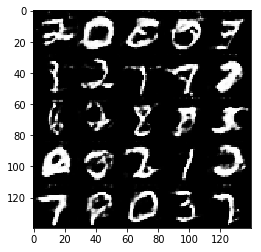

Epoch 1/2... Discriminator Loss: 1.4401... Generator Loss: 1.1123
Epoch 1/2... Discriminator Loss: 1.0633... Generator Loss: 0.8222
Epoch 1/2... Discriminator Loss: 1.0748... Generator Loss: 0.8406
Epoch 1/2... Discriminator Loss: 1.3114... Generator Loss: 0.6102
Epoch 1/2... Discriminator Loss: 1.0726... Generator Loss: 0.8392
Epoch 1/2... Discriminator Loss: 1.4247... Generator Loss: 0.5830
Epoch 1/2... Discriminator Loss: 1.0295... Generator Loss: 1.0155
Epoch 1/2... Discriminator Loss: 1.1025... Generator Loss: 0.8209
Epoch 1/2... Discriminator Loss: 1.4096... Generator Loss: 2.0493
Epoch 1/2... Discriminator Loss: 1.1746... Generator Loss: 0.7581


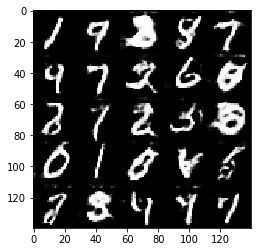

Epoch 1/2... Discriminator Loss: 1.3061... Generator Loss: 0.6104
Epoch 1/2... Discriminator Loss: 1.2924... Generator Loss: 0.6639
Epoch 1/2... Discriminator Loss: 1.3563... Generator Loss: 0.6080
Epoch 2/2... Discriminator Loss: 1.0118... Generator Loss: 1.2088
Epoch 2/2... Discriminator Loss: 1.0140... Generator Loss: 1.4452
Epoch 2/2... Discriminator Loss: 0.9983... Generator Loss: 0.9570
Epoch 2/2... Discriminator Loss: 1.2900... Generator Loss: 1.4745
Epoch 2/2... Discriminator Loss: 1.0806... Generator Loss: 0.9327
Epoch 2/2... Discriminator Loss: 1.0856... Generator Loss: 0.8647
Epoch 2/2... Discriminator Loss: 1.0850... Generator Loss: 1.3726


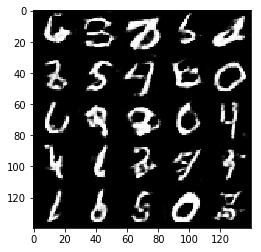

Epoch 2/2... Discriminator Loss: 1.3087... Generator Loss: 1.5195
Epoch 2/2... Discriminator Loss: 1.4359... Generator Loss: 0.5494
Epoch 2/2... Discriminator Loss: 1.0322... Generator Loss: 0.9202
Epoch 2/2... Discriminator Loss: 1.1300... Generator Loss: 0.7778
Epoch 2/2... Discriminator Loss: 1.4648... Generator Loss: 1.5237
Epoch 2/2... Discriminator Loss: 1.0652... Generator Loss: 1.0542
Epoch 2/2... Discriminator Loss: 1.2477... Generator Loss: 0.6623
Epoch 2/2... Discriminator Loss: 1.1155... Generator Loss: 0.8018
Epoch 2/2... Discriminator Loss: 1.2585... Generator Loss: 0.6401
Epoch 2/2... Discriminator Loss: 1.3395... Generator Loss: 0.6196


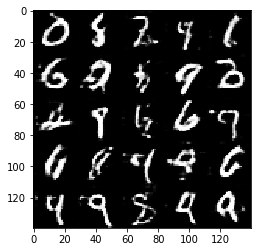

Epoch 2/2... Discriminator Loss: 1.1917... Generator Loss: 0.7698
Epoch 2/2... Discriminator Loss: 1.1279... Generator Loss: 0.7561
Epoch 2/2... Discriminator Loss: 1.0141... Generator Loss: 1.4589
Epoch 2/2... Discriminator Loss: 0.9427... Generator Loss: 0.9844
Epoch 2/2... Discriminator Loss: 0.9286... Generator Loss: 1.1926
Epoch 2/2... Discriminator Loss: 0.9756... Generator Loss: 0.9819
Epoch 2/2... Discriminator Loss: 1.0552... Generator Loss: 1.3260
Epoch 2/2... Discriminator Loss: 1.1243... Generator Loss: 0.8451
Epoch 2/2... Discriminator Loss: 1.4434... Generator Loss: 0.5851
Epoch 2/2... Discriminator Loss: 0.8946... Generator Loss: 1.0519


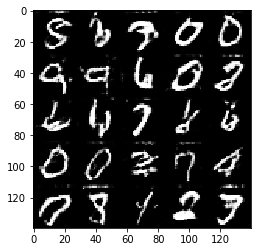

Epoch 2/2... Discriminator Loss: 1.4238... Generator Loss: 0.5859
Epoch 2/2... Discriminator Loss: 1.3192... Generator Loss: 0.6442
Epoch 2/2... Discriminator Loss: 1.5080... Generator Loss: 0.5572
Epoch 2/2... Discriminator Loss: 1.3006... Generator Loss: 0.6761
Epoch 2/2... Discriminator Loss: 1.4453... Generator Loss: 1.9876
Epoch 2/2... Discriminator Loss: 1.2224... Generator Loss: 0.6878
Epoch 2/2... Discriminator Loss: 1.3285... Generator Loss: 0.6135
Epoch 2/2... Discriminator Loss: 0.9717... Generator Loss: 1.0564
Epoch 2/2... Discriminator Loss: 0.9770... Generator Loss: 1.7329
Epoch 2/2... Discriminator Loss: 0.9008... Generator Loss: 1.7224


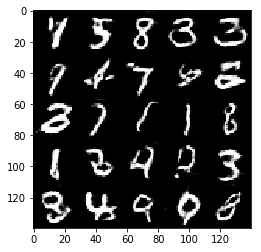

Epoch 2/2... Discriminator Loss: 1.4595... Generator Loss: 0.5745
Epoch 2/2... Discriminator Loss: 1.1226... Generator Loss: 0.8075
Epoch 2/2... Discriminator Loss: 1.0460... Generator Loss: 0.8709
Epoch 2/2... Discriminator Loss: 0.9544... Generator Loss: 1.0314
Epoch 2/2... Discriminator Loss: 1.0532... Generator Loss: 1.1405
Epoch 2/2... Discriminator Loss: 1.2662... Generator Loss: 0.6620
Epoch 2/2... Discriminator Loss: 1.2264... Generator Loss: 0.8095
Epoch 2/2... Discriminator Loss: 1.4954... Generator Loss: 0.5897
Epoch 2/2... Discriminator Loss: 0.8594... Generator Loss: 1.4842
Epoch 2/2... Discriminator Loss: 1.2200... Generator Loss: 0.7416


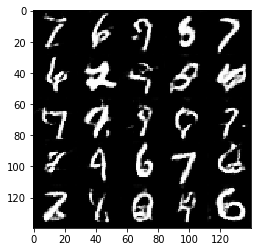

Epoch 2/2... Discriminator Loss: 1.0865... Generator Loss: 0.7957
Epoch 2/2... Discriminator Loss: 0.9454... Generator Loss: 1.0582
Epoch 2/2... Discriminator Loss: 0.8201... Generator Loss: 1.3492
Epoch 2/2... Discriminator Loss: 1.6206... Generator Loss: 0.5674
Epoch 2/2... Discriminator Loss: 0.9433... Generator Loss: 1.0289
Epoch 2/2... Discriminator Loss: 0.7371... Generator Loss: 1.3637
Epoch 2/2... Discriminator Loss: 1.7238... Generator Loss: 2.5454
Epoch 2/2... Discriminator Loss: 1.0835... Generator Loss: 1.3798
Epoch 2/2... Discriminator Loss: 0.9852... Generator Loss: 0.8877
Epoch 2/2... Discriminator Loss: 1.1120... Generator Loss: 0.8265


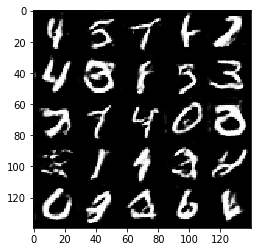

Epoch 2/2... Discriminator Loss: 1.1330... Generator Loss: 0.7359
Epoch 2/2... Discriminator Loss: 0.8888... Generator Loss: 1.5059
Epoch 2/2... Discriminator Loss: 1.0316... Generator Loss: 0.9843
Epoch 2/2... Discriminator Loss: 1.5053... Generator Loss: 0.5803
Epoch 2/2... Discriminator Loss: 1.3777... Generator Loss: 0.6206
Epoch 2/2... Discriminator Loss: 0.8321... Generator Loss: 1.6108
Epoch 2/2... Discriminator Loss: 1.2526... Generator Loss: 0.6551
Epoch 2/2... Discriminator Loss: 1.0255... Generator Loss: 0.8830
Epoch 2/2... Discriminator Loss: 0.7484... Generator Loss: 1.3205
Epoch 2/2... Discriminator Loss: 1.0063... Generator Loss: 1.2120


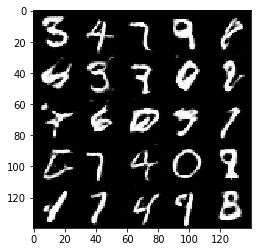

Epoch 2/2... Discriminator Loss: 0.8997... Generator Loss: 1.0699
Epoch 2/2... Discriminator Loss: 1.5311... Generator Loss: 0.5260
Epoch 2/2... Discriminator Loss: 1.4067... Generator Loss: 0.6171
Epoch 2/2... Discriminator Loss: 1.2971... Generator Loss: 0.6718
Epoch 2/2... Discriminator Loss: 1.0424... Generator Loss: 1.7336
Epoch 2/2... Discriminator Loss: 1.0826... Generator Loss: 0.7912
Epoch 2/2... Discriminator Loss: 0.9734... Generator Loss: 0.9553
Epoch 2/2... Discriminator Loss: 0.9202... Generator Loss: 1.0289
Epoch 2/2... Discriminator Loss: 0.7151... Generator Loss: 1.4680
Epoch 2/2... Discriminator Loss: 0.7742... Generator Loss: 1.2221


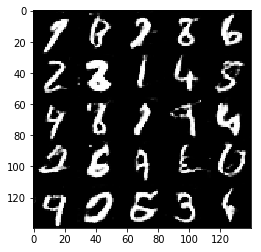

Epoch 2/2... Discriminator Loss: 1.0347... Generator Loss: 1.3451
Epoch 2/2... Discriminator Loss: 1.4195... Generator Loss: 0.5852
Epoch 2/2... Discriminator Loss: 0.8376... Generator Loss: 2.0441
Epoch 2/2... Discriminator Loss: 1.3029... Generator Loss: 2.0645
Epoch 2/2... Discriminator Loss: 0.8231... Generator Loss: 1.3074
Epoch 2/2... Discriminator Loss: 1.8076... Generator Loss: 2.5733
Epoch 2/2... Discriminator Loss: 1.8134... Generator Loss: 0.4574
Epoch 2/2... Discriminator Loss: 1.2489... Generator Loss: 0.6691
Epoch 2/2... Discriminator Loss: 0.7470... Generator Loss: 1.3977
Epoch 2/2... Discriminator Loss: 0.8512... Generator Loss: 1.4225


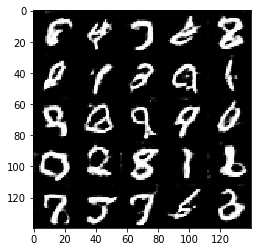

Epoch 2/2... Discriminator Loss: 1.0592... Generator Loss: 2.0829
Epoch 2/2... Discriminator Loss: 0.7871... Generator Loss: 1.2461
Epoch 2/2... Discriminator Loss: 1.1609... Generator Loss: 2.7844
Epoch 2/2... Discriminator Loss: 0.9350... Generator Loss: 1.3194
Epoch 2/2... Discriminator Loss: 0.9546... Generator Loss: 1.0442
Epoch 2/2... Discriminator Loss: 0.6473... Generator Loss: 1.7233
Epoch 2/2... Discriminator Loss: 1.5378... Generator Loss: 0.5416


In [15]:
batch_size = 64
z_dim = 128
learning_rate = 0.0007
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6024... Generator Loss: 3.5505
Epoch 1/1... Discriminator Loss: 0.4207... Generator Loss: 10.5261
Epoch 1/1... Discriminator Loss: 1.6770... Generator Loss: 1.1700
Epoch 1/1... Discriminator Loss: 0.6982... Generator Loss: 1.5240
Epoch 1/1... Discriminator Loss: 0.7547... Generator Loss: 2.1761
Epoch 1/1... Discriminator Loss: 0.7852... Generator Loss: 2.0053
Epoch 1/1... Discriminator Loss: 0.6560... Generator Loss: 2.4384
Epoch 1/1... Discriminator Loss: 0.5748... Generator Loss: 2.2484
Epoch 1/1... Discriminator Loss: 0.5433... Generator Loss: 2.3493
Epoch 1/1... Discriminator Loss: 0.4165... Generator Loss: 3.5492


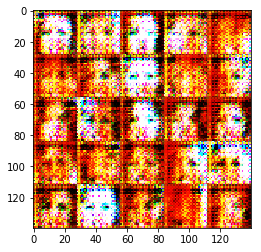

Epoch 1/1... Discriminator Loss: 0.4084... Generator Loss: 3.0041
Epoch 1/1... Discriminator Loss: 0.4040... Generator Loss: 6.1895
Epoch 1/1... Discriminator Loss: 2.5538... Generator Loss: 0.4019
Epoch 1/1... Discriminator Loss: 0.8062... Generator Loss: 1.3789
Epoch 1/1... Discriminator Loss: 1.7779... Generator Loss: 0.5790
Epoch 1/1... Discriminator Loss: 2.9523... Generator Loss: 4.7191
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.6542
Epoch 1/1... Discriminator Loss: 1.3225... Generator Loss: 2.2287
Epoch 1/1... Discriminator Loss: 1.9682... Generator Loss: 0.4540
Epoch 1/1... Discriminator Loss: 1.2479... Generator Loss: 0.9356


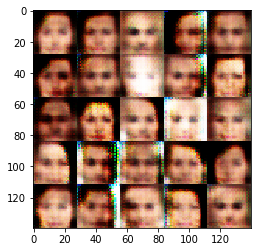

Epoch 1/1... Discriminator Loss: 0.8820... Generator Loss: 1.8155
Epoch 1/1... Discriminator Loss: 1.4874... Generator Loss: 0.5487
Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.5407
Epoch 1/1... Discriminator Loss: 1.1284... Generator Loss: 0.8239
Epoch 1/1... Discriminator Loss: 1.2671... Generator Loss: 0.6937
Epoch 1/1... Discriminator Loss: 1.0880... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 1.0458... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 1.0405... Generator Loss: 1.0951
Epoch 1/1... Discriminator Loss: 0.9156... Generator Loss: 1.0466
Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 1.1779


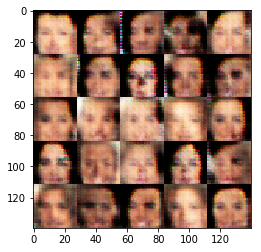

Epoch 1/1... Discriminator Loss: 1.1845... Generator Loss: 0.7251
Epoch 1/1... Discriminator Loss: 0.6631... Generator Loss: 1.6163
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 2.1831
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.9081
Epoch 1/1... Discriminator Loss: 1.1697... Generator Loss: 0.9927
Epoch 1/1... Discriminator Loss: 1.6477... Generator Loss: 2.9857
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 0.8466... Generator Loss: 1.6430
Epoch 1/1... Discriminator Loss: 0.9837... Generator Loss: 1.0691
Epoch 1/1... Discriminator Loss: 1.2926... Generator Loss: 0.6633


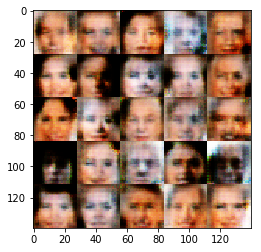

Epoch 1/1... Discriminator Loss: 1.4641... Generator Loss: 0.5599
Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 1.3635
Epoch 1/1... Discriminator Loss: 0.5784... Generator Loss: 2.1353
Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 0.8413
Epoch 1/1... Discriminator Loss: 1.1766... Generator Loss: 0.9332
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 1.0541... Generator Loss: 0.8670
Epoch 1/1... Discriminator Loss: 1.2337... Generator Loss: 1.0832
Epoch 1/1... Discriminator Loss: 1.2545... Generator Loss: 0.6341
Epoch 1/1... Discriminator Loss: 1.1801... Generator Loss: 0.9213


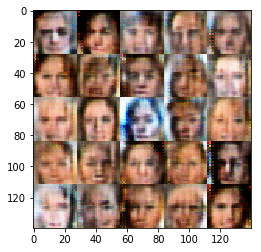

Epoch 1/1... Discriminator Loss: 1.5939... Generator Loss: 1.8234
Epoch 1/1... Discriminator Loss: 1.2429... Generator Loss: 1.1331
Epoch 1/1... Discriminator Loss: 1.5889... Generator Loss: 0.5514
Epoch 1/1... Discriminator Loss: 1.2339... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.3474... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 1.0096... Generator Loss: 1.0681
Epoch 1/1... Discriminator Loss: 1.2052... Generator Loss: 0.8335
Epoch 1/1... Discriminator Loss: 1.1482... Generator Loss: 0.9789
Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.5392
Epoch 1/1... Discriminator Loss: 1.2287... Generator Loss: 0.6726


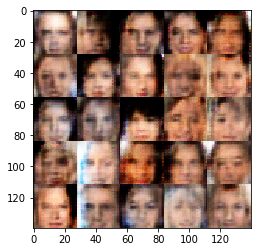

Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 1.5259... Generator Loss: 0.4963
Epoch 1/1... Discriminator Loss: 1.0808... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 1.6970
Epoch 1/1... Discriminator Loss: 1.0421... Generator Loss: 1.0411
Epoch 1/1... Discriminator Loss: 1.2812... Generator Loss: 1.0558
Epoch 1/1... Discriminator Loss: 1.7164... Generator Loss: 1.3341
Epoch 1/1... Discriminator Loss: 1.1099... Generator Loss: 0.8492
Epoch 1/1... Discriminator Loss: 1.1971... Generator Loss: 0.9512
Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 1.6222


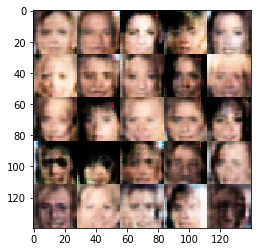

Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 1.5671
Epoch 1/1... Discriminator Loss: 1.1264... Generator Loss: 0.9917
Epoch 1/1... Discriminator Loss: 1.0396... Generator Loss: 0.9187
Epoch 1/1... Discriminator Loss: 1.3137... Generator Loss: 0.7419
Epoch 1/1... Discriminator Loss: 1.1921... Generator Loss: 0.6941
Epoch 1/1... Discriminator Loss: 1.0263... Generator Loss: 1.3646
Epoch 1/1... Discriminator Loss: 1.2869... Generator Loss: 1.0157
Epoch 1/1... Discriminator Loss: 1.1841... Generator Loss: 0.8952
Epoch 1/1... Discriminator Loss: 1.0763... Generator Loss: 0.8752
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.8528


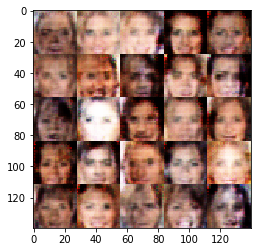

Epoch 1/1... Discriminator Loss: 1.1338... Generator Loss: 1.0306
Epoch 1/1... Discriminator Loss: 1.1914... Generator Loss: 0.9368
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.6626
Epoch 1/1... Discriminator Loss: 1.1107... Generator Loss: 1.6452
Epoch 1/1... Discriminator Loss: 1.2219... Generator Loss: 0.7329
Epoch 1/1... Discriminator Loss: 1.5330... Generator Loss: 1.5435
Epoch 1/1... Discriminator Loss: 1.0872... Generator Loss: 1.0050
Epoch 1/1... Discriminator Loss: 1.0153... Generator Loss: 0.9026
Epoch 1/1... Discriminator Loss: 1.2045... Generator Loss: 0.7691
Epoch 1/1... Discriminator Loss: 1.2819... Generator Loss: 0.6743


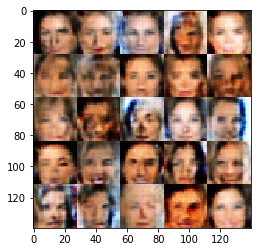

Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.7867
Epoch 1/1... Discriminator Loss: 1.5565... Generator Loss: 0.4919
Epoch 1/1... Discriminator Loss: 1.2339... Generator Loss: 0.9278
Epoch 1/1... Discriminator Loss: 1.8943... Generator Loss: 1.8893
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.9206
Epoch 1/1... Discriminator Loss: 1.9407... Generator Loss: 0.3980
Epoch 1/1... Discriminator Loss: 1.0024... Generator Loss: 0.8240
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.6345
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 1.1743


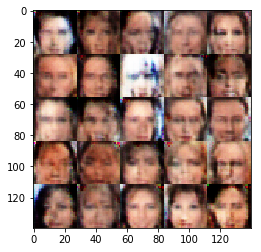

Epoch 1/1... Discriminator Loss: 1.1773... Generator Loss: 0.8911
Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 1.1569
Epoch 1/1... Discriminator Loss: 1.2524... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 1.2015... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.2019... Generator Loss: 1.0039
Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.8659
Epoch 1/1... Discriminator Loss: 1.4410... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 0.9755... Generator Loss: 1.1213
Epoch 1/1... Discriminator Loss: 1.1590... Generator Loss: 1.3161
Epoch 1/1... Discriminator Loss: 1.4482... Generator Loss: 0.6727


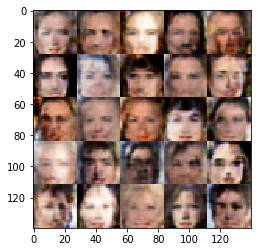

Epoch 1/1... Discriminator Loss: 1.1947... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 0.6735
Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 1.1333
Epoch 1/1... Discriminator Loss: 1.3207... Generator Loss: 0.6975
Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 0.6183
Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 0.7411
Epoch 1/1... Discriminator Loss: 1.4585... Generator Loss: 1.0603
Epoch 1/1... Discriminator Loss: 1.1703... Generator Loss: 0.9115
Epoch 1/1... Discriminator Loss: 1.1887... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 1.0106


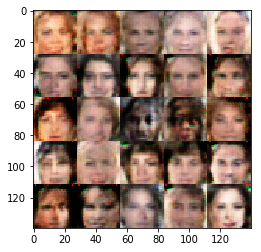

Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.7659
Epoch 1/1... Discriminator Loss: 1.2070... Generator Loss: 0.9774
Epoch 1/1... Discriminator Loss: 1.5391... Generator Loss: 0.6088
Epoch 1/1... Discriminator Loss: 1.1341... Generator Loss: 1.1631
Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.6123
Epoch 1/1... Discriminator Loss: 1.1189... Generator Loss: 0.7960
Epoch 1/1... Discriminator Loss: 1.1181... Generator Loss: 0.8705
Epoch 1/1... Discriminator Loss: 1.2062... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 1.2605
Epoch 1/1... Discriminator Loss: 0.6174... Generator Loss: 1.8344


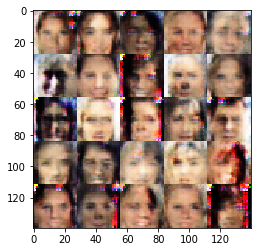

Epoch 1/1... Discriminator Loss: 0.7613... Generator Loss: 1.2555
Epoch 1/1... Discriminator Loss: 1.0810... Generator Loss: 1.6152
Epoch 1/1... Discriminator Loss: 0.7464... Generator Loss: 1.2588
Epoch 1/1... Discriminator Loss: 2.2772... Generator Loss: 0.3673
Epoch 1/1... Discriminator Loss: 1.0296... Generator Loss: 1.0608
Epoch 1/1... Discriminator Loss: 1.6774... Generator Loss: 0.5102
Epoch 1/1... Discriminator Loss: 1.2945... Generator Loss: 0.6787
Epoch 1/1... Discriminator Loss: 1.3211... Generator Loss: 0.6508
Epoch 1/1... Discriminator Loss: 1.2670... Generator Loss: 1.3063
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.8248


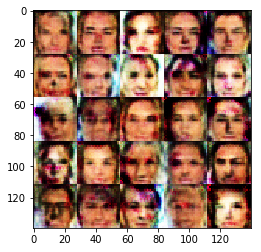

Epoch 1/1... Discriminator Loss: 1.2040... Generator Loss: 0.8380
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.5476
Epoch 1/1... Discriminator Loss: 1.5285... Generator Loss: 1.2987
Epoch 1/1... Discriminator Loss: 1.3212... Generator Loss: 0.6945
Epoch 1/1... Discriminator Loss: 1.1527... Generator Loss: 0.8678
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.6032
Epoch 1/1... Discriminator Loss: 1.1987... Generator Loss: 0.8333
Epoch 1/1... Discriminator Loss: 1.2700... Generator Loss: 0.8599
Epoch 1/1... Discriminator Loss: 1.1738... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.1233... Generator Loss: 1.0204


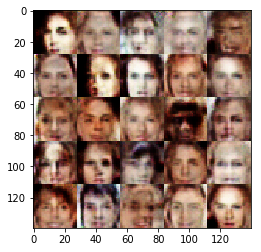

Epoch 1/1... Discriminator Loss: 1.2019... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 1.2013... Generator Loss: 0.9856
Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 0.6529
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 1.1263
Epoch 1/1... Discriminator Loss: 1.2020... Generator Loss: 1.1401
Epoch 1/1... Discriminator Loss: 1.0885... Generator Loss: 1.0592
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.5751
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.6009
Epoch 1/1... Discriminator Loss: 1.2783... Generator Loss: 1.1374
Epoch 1/1... Discriminator Loss: 1.1545... Generator Loss: 0.9996


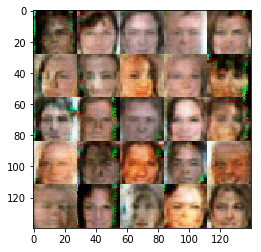

Epoch 1/1... Discriminator Loss: 1.0670... Generator Loss: 0.8350
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 1.4801
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 1.4494
Epoch 1/1... Discriminator Loss: 1.5741... Generator Loss: 0.5094
Epoch 1/1... Discriminator Loss: 1.3272... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 1.2342... Generator Loss: 0.8804
Epoch 1/1... Discriminator Loss: 1.2473... Generator Loss: 0.7177
Epoch 1/1... Discriminator Loss: 1.1709... Generator Loss: 0.7450
Epoch 1/1... Discriminator Loss: 2.2689... Generator Loss: 2.1245
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.8277


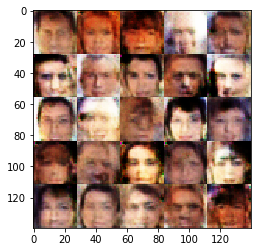

Epoch 1/1... Discriminator Loss: 1.5094... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 0.9971... Generator Loss: 0.8987
Epoch 1/1... Discriminator Loss: 1.4468... Generator Loss: 0.4991
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.5571
Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.6761
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.5645
Epoch 1/1... Discriminator Loss: 1.1994... Generator Loss: 0.9314
Epoch 1/1... Discriminator Loss: 1.6480... Generator Loss: 1.4994
Epoch 1/1... Discriminator Loss: 1.3474... Generator Loss: 0.6075
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.6330


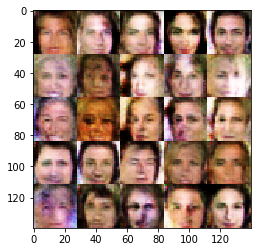

Epoch 1/1... Discriminator Loss: 1.1152... Generator Loss: 0.9846
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 0.7189
Epoch 1/1... Discriminator Loss: 1.2834... Generator Loss: 1.2624
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.7060
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.5639
Epoch 1/1... Discriminator Loss: 1.3631... Generator Loss: 0.8917
Epoch 1/1... Discriminator Loss: 0.9742... Generator Loss: 1.2825
Epoch 1/1... Discriminator Loss: 2.0222... Generator Loss: 2.3160
Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 0.8647
Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.9701


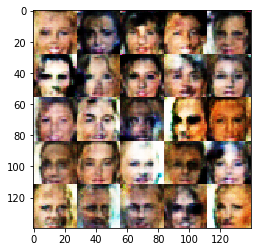

Epoch 1/1... Discriminator Loss: 1.3024... Generator Loss: 1.7582
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.5735
Epoch 1/1... Discriminator Loss: 1.3325... Generator Loss: 0.8702
Epoch 1/1... Discriminator Loss: 1.3207... Generator Loss: 0.9452
Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 0.9111
Epoch 1/1... Discriminator Loss: 1.2615... Generator Loss: 0.7126
Epoch 1/1... Discriminator Loss: 0.8696... Generator Loss: 1.2112
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.5645
Epoch 1/1... Discriminator Loss: 1.1765... Generator Loss: 0.6474
Epoch 1/1... Discriminator Loss: 1.2528... Generator Loss: 1.0636


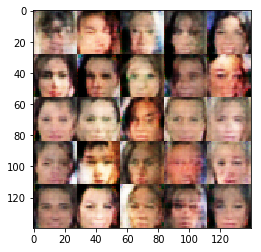

Epoch 1/1... Discriminator Loss: 1.4521... Generator Loss: 0.6210
Epoch 1/1... Discriminator Loss: 1.2507... Generator Loss: 0.6835
Epoch 1/1... Discriminator Loss: 1.3039... Generator Loss: 0.9765
Epoch 1/1... Discriminator Loss: 1.2229... Generator Loss: 1.0618
Epoch 1/1... Discriminator Loss: 1.2896... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 1.5019... Generator Loss: 0.7187
Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.7283
Epoch 1/1... Discriminator Loss: 1.6557... Generator Loss: 0.4683
Epoch 1/1... Discriminator Loss: 1.1108... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 1.8494... Generator Loss: 1.5971


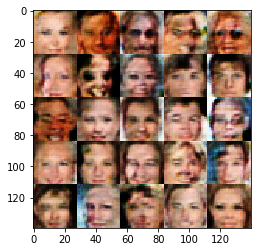

Epoch 1/1... Discriminator Loss: 1.2778... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 1.2465... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 1.1968... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 1.3087... Generator Loss: 0.8839
Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 0.8451
Epoch 1/1... Discriminator Loss: 1.5179... Generator Loss: 0.6365
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 1.2581... Generator Loss: 0.8945
Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 1.6615
Epoch 1/1... Discriminator Loss: 1.1079... Generator Loss: 0.8085


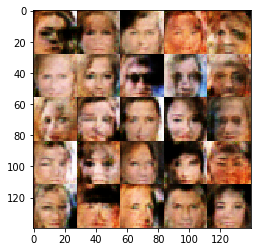

Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.9857
Epoch 1/1... Discriminator Loss: 1.1211... Generator Loss: 0.9246
Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 1.1016
Epoch 1/1... Discriminator Loss: 1.0463... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 1.2310... Generator Loss: 1.2110
Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 0.9710
Epoch 1/1... Discriminator Loss: 1.2014... Generator Loss: 0.9495
Epoch 1/1... Discriminator Loss: 1.3131... Generator Loss: 1.1426
Epoch 1/1... Discriminator Loss: 1.4581... Generator Loss: 0.5855
Epoch 1/1... Discriminator Loss: 1.4684... Generator Loss: 0.6211


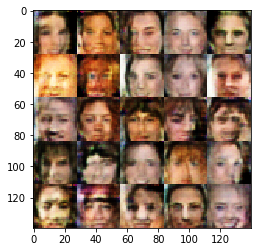

Epoch 1/1... Discriminator Loss: 1.7952... Generator Loss: 0.4243
Epoch 1/1... Discriminator Loss: 1.0899... Generator Loss: 0.9082
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 0.7646
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.6695
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.6943
Epoch 1/1... Discriminator Loss: 1.2772... Generator Loss: 0.6485
Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.2641... Generator Loss: 0.7164
Epoch 1/1... Discriminator Loss: 1.4586... Generator Loss: 0.6512


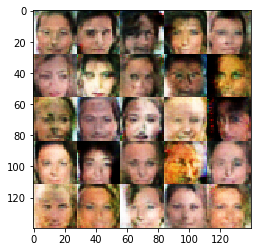

Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.8785
Epoch 1/1... Discriminator Loss: 1.6770... Generator Loss: 0.6224
Epoch 1/1... Discriminator Loss: 1.3231... Generator Loss: 0.6274
Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 0.8720
Epoch 1/1... Discriminator Loss: 1.0931... Generator Loss: 0.9138
Epoch 1/1... Discriminator Loss: 1.2623... Generator Loss: 1.0475
Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 0.6902
Epoch 1/1... Discriminator Loss: 0.9823... Generator Loss: 1.1250
Epoch 1/1... Discriminator Loss: 1.0610... Generator Loss: 0.8034
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.5500


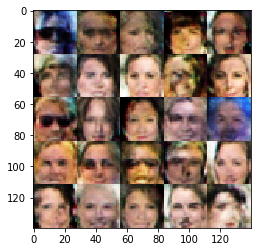

Epoch 1/1... Discriminator Loss: 1.2920... Generator Loss: 0.6363
Epoch 1/1... Discriminator Loss: 1.1796... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 1.2171... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.0514... Generator Loss: 0.8826
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.8499
Epoch 1/1... Discriminator Loss: 1.1606... Generator Loss: 0.9000
Epoch 1/1... Discriminator Loss: 1.4792... Generator Loss: 0.6188
Epoch 1/1... Discriminator Loss: 1.2819... Generator Loss: 0.6515
Epoch 1/1... Discriminator Loss: 1.4382... Generator Loss: 0.9261
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.7034


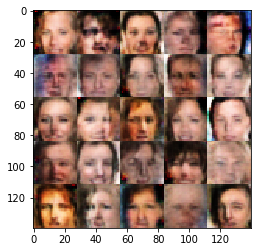

Epoch 1/1... Discriminator Loss: 1.5405... Generator Loss: 0.5125
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.9999
Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 0.6981
Epoch 1/1... Discriminator Loss: 1.3188... Generator Loss: 1.5033
Epoch 1/1... Discriminator Loss: 1.7032... Generator Loss: 0.4615
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.6188
Epoch 1/1... Discriminator Loss: 1.1071... Generator Loss: 0.9573
Epoch 1/1... Discriminator Loss: 0.9136... Generator Loss: 1.4463
Epoch 1/1... Discriminator Loss: 1.1947... Generator Loss: 0.9107
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.5931


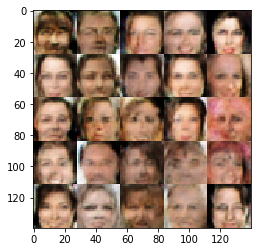

Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 1.3852
Epoch 1/1... Discriminator Loss: 1.4587... Generator Loss: 0.6118
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.6388
Epoch 1/1... Discriminator Loss: 1.5982... Generator Loss: 0.4757
Epoch 1/1... Discriminator Loss: 1.2920... Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 0.5880
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 1.0405
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 1.2942
Epoch 1/1... Discriminator Loss: 1.2706... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 1.2158... Generator Loss: 0.8142


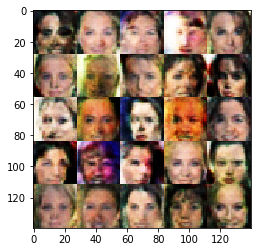

Epoch 1/1... Discriminator Loss: 1.2572... Generator Loss: 0.6784
Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.6100
Epoch 1/1... Discriminator Loss: 1.2273... Generator Loss: 1.0185
Epoch 1/1... Discriminator Loss: 1.0950... Generator Loss: 1.3961
Epoch 1/1... Discriminator Loss: 1.3329... Generator Loss: 0.9624
Epoch 1/1... Discriminator Loss: 1.2847... Generator Loss: 0.8091
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.6861
Epoch 1/1... Discriminator Loss: 1.0264... Generator Loss: 1.0404
Epoch 1/1... Discriminator Loss: 1.3185... Generator Loss: 0.7051
Epoch 1/1... Discriminator Loss: 1.1916... Generator Loss: 0.7918


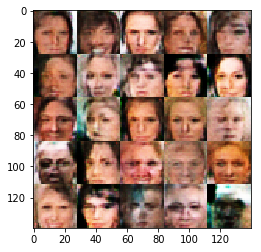

Epoch 1/1... Discriminator Loss: 1.1998... Generator Loss: 0.8420
Epoch 1/1... Discriminator Loss: 1.2635... Generator Loss: 1.2497
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.5837
Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.5828
Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 1.3270... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.2914... Generator Loss: 0.8990
Epoch 1/1... Discriminator Loss: 1.1490... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.5485... Generator Loss: 0.9351
Epoch 1/1... Discriminator Loss: 1.2556... Generator Loss: 0.8567


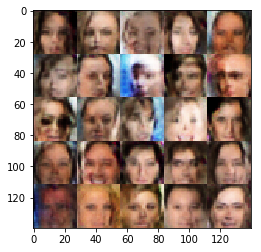

Epoch 1/1... Discriminator Loss: 1.4680... Generator Loss: 0.8545
Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 0.6176
Epoch 1/1... Discriminator Loss: 1.2974... Generator Loss: 0.6140
Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 1.2272... Generator Loss: 0.8864
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.8338
Epoch 1/1... Discriminator Loss: 1.1665... Generator Loss: 0.7451
Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.6213
Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 0.6828


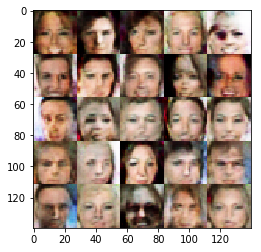

Epoch 1/1... Discriminator Loss: 1.5490... Generator Loss: 1.6191
Epoch 1/1... Discriminator Loss: 1.0694... Generator Loss: 0.9130
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.7106
Epoch 1/1... Discriminator Loss: 1.4633... Generator Loss: 0.5899
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.6426
Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 0.7907


In [16]:
batch_size = 64
z_dim = 128
learning_rate = 0.0007
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.